In [2]:
"""
Equivariant GNN-based TSP Diffusion Solver
Based on EDM (Hoogeboom et al., 2022) with categorical diffusion from DIFUSCO
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import math


# ============================================================================
# PART 1: DATASET (From permutation-based code with better visualization)
# ============================================================================

class TSPDataset(Dataset):
    """TSP Dataset with edge-based representation"""
    
    def __init__(self, filename, n_instances=None):
        self.data = []
        self.n_cities = None
        
        with open(filename, 'r') as f:
            lines = f.readlines()
        
        if n_instances:
            lines = lines[:n_instances]
        
        print(f"Loading {len(lines)} TSP instances from {filename}")
        
        for line_idx, line in enumerate(lines):
            parts = line.strip().split()
            try:
                output_idx = parts.index('output')
                coords_flat = list(map(float, parts[:output_idx]))
                n_cities = len(coords_flat) // 2
                
                if self.n_cities is None:
                    self.n_cities = n_cities
                elif self.n_cities != n_cities:
                    continue
                
                coords = np.array(coords_flat).reshape(n_cities, 2)
                
                # Parse tour - subtract 1 to make 0-indexed
                tour_parts = parts[output_idx + 1:]
                tour = [int(x) - 1 for x in tour_parts]
                
                # Store both coordinates and tour
                self.data.append({
                    'coordinates': coords.astype(np.float32),
                    'tour': np.array(tour[:n_cities], dtype=np.int64)  # Remove duplicate if exists
                })
                
            except (ValueError, IndexError) as e:
                continue
        
        # Pre-compute graph structure
        self._precompute_graph_structure()
        
        print(f"Loaded {len(self.data)} instances with {self.n_cities} cities")
    
    def _precompute_graph_structure(self):
        """Pre-compute complete graph edge structure"""
        n = self.n_cities
        edge_index = []
        
        # Create all directed edges
        for i in range(n):
            for j in range(n):
                if i != j:
                    edge_index.append([i, j])
        
        self.edge_index = torch.tensor(edge_index).T.long()
        self.n_edges = len(edge_index)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        coords = torch.tensor(item['coordinates'])
        tour = torch.tensor(item['tour'])
        
        # Create binary adjacency matrix for edges
        adj_matrix = torch.zeros(self.n_edges, dtype=torch.float32)
        tour_np = item['tour']
        for i in range(len(tour_np)):
            u = tour_np[i]
            v = tour_np[(i + 1) % len(tour_np)]
            # Find this edge in edge_index
            edge_idx = (self.edge_index[0] == u) & (self.edge_index[1] == v)
            adj_matrix[edge_idx] = 1.0
        
        return coords, adj_matrix, tour


# ============================================================================
# PART 2: CATEGORICAL DIFFUSION
# ============================================================================

class CategoricalDiffusion:
    """Categorical Diffusion for discrete variables"""
    
    def __init__(self, T=1000, schedule='linear'):
        self.T = T
        
        # Linear beta schedule
        if schedule == 'linear':
            b0 = 1e-4
            bT = 2e-2
            self.beta = np.linspace(b0, bT, T)
        
        # Transition matrices for binary variables
        beta = self.beta.reshape((-1, 1, 1))
        eye = np.eye(2).reshape((1, 2, 2))
        ones = np.ones((2, 2)).reshape((1, 2, 2))
        
        self.Qs = (1 - beta) * eye + (beta / 2) * ones
        
        # Cumulative product
        Q_bar = [np.eye(2)]
        for Q in self.Qs:
            Q_bar.append(Q_bar[-1] @ Q)
        self.Q_bar = np.stack(Q_bar[1:], axis=0)  # Shape: (T, 2, 2)
    
    def sample(self, x0_onehot, t):
        """Forward diffusion: add noise to x0"""
        batch_size, n_edges, _ = x0_onehot.shape
        
        Q_bar = torch.from_numpy(self.Q_bar[t - 1]).float().to(x0_onehot.device)
        Q_bar_expanded = Q_bar.unsqueeze(1).expand(batch_size, n_edges, 2, 2)
        
        xt_probs = torch.matmul(x0_onehot.unsqueeze(-2), Q_bar_expanded).squeeze(-2)
        xt = torch.bernoulli(xt_probs[..., 1].clamp(0, 1))
        return xt
    
    def posterior(self, xt, t, x0_pred_prob, target_t=None):
        """Compute posterior q(x_{t-1} | x_t, x_0)"""
        if target_t is None:
            target_t = t - 1
        
        batch_size, n_edges = xt.shape
        device = x0_pred_prob.device
        
        # Get transition matrices
        Q_t = np.linalg.inv(self.Q_bar[target_t]) @ self.Q_bar[t]
        Q_t = torch.from_numpy(Q_t).float().to(device)
        
        Q_bar_t_source = torch.from_numpy(self.Q_bar[t]).float().to(device)
        Q_bar_t_target = torch.from_numpy(self.Q_bar[target_t]).float().to(device)
        
        # Convert xt to one-hot
        xt_onehot = F.one_hot(xt.long(), num_classes=2).float()
        
        # Compute transition probabilities
        x_t_target_prob_part_1 = torch.matmul(xt_onehot, Q_t.permute(1, 0))
        
        # Compute normalizing factors
        Q_bar_source_xt = torch.matmul(xt_onehot, Q_bar_t_source.permute(1, 0))
        norm_factor = Q_bar_source_xt.sum(dim=-1, keepdim=True) + 1e-8
        
        # First term
        x_t_target_prob = x_t_target_prob_part_1 * Q_bar_t_target[0]
        x_t_target_prob = x_t_target_prob / norm_factor
        
        # Combine with predicted x0
        posterior_prob = x_t_target_prob[..., 1] * x0_pred_prob[..., 0]
        
        # Second term
        x_t_target_prob_2 = x_t_target_prob_part_1 * Q_bar_t_target[1]
        Q_bar_source_xt_2 = torch.matmul(xt_onehot, Q_bar_t_source[1:2].T)
        norm_factor_2 = Q_bar_source_xt_2.sum(dim=-1, keepdim=True) + 1e-8
        x_t_target_prob_2 = x_t_target_prob_2 / norm_factor_2
        
        posterior_prob += x_t_target_prob_2[..., 1] * x0_pred_prob[..., 1]
        
        if target_t > 0:
            return torch.bernoulli(posterior_prob.clamp(0, 1))
        else:
            return posterior_prob.clamp(min=0)


# ============================================================================
# PART 3: EQUIVARIANT GNN (Based on EDM)
# ============================================================================

def timestep_embedding(timesteps, dim, max_period=10000):
    """Create sinusoidal timestep embeddings"""
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


class EGNNLayer(nn.Module):
    """E(n) Equivariant Graph Neural Network Layer"""
    
    def __init__(self, node_dim, edge_dim, hidden_dim, coord_dim=2):
        super().__init__()
        self.coord_dim = coord_dim
        self.hidden_dim = hidden_dim
        
        # Message network
        self.message_mlp = nn.Sequential(
            nn.Linear(node_dim * 2 + edge_dim + 1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Coordinate network (outputs scalar for coordinate update)
        self.coord_mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 1)
        )
        
        # Node update network
        self.node_mlp = nn.Sequential(
            nn.Linear(node_dim + hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, node_dim)
        )
        
        # Edge update network
        self.edge_mlp = nn.Sequential(
            nn.Linear(edge_dim + hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, edge_dim)
        )
        
        # Normalization
        self.node_norm = nn.LayerNorm(node_dim)
        self.edge_norm = nn.LayerNorm(edge_dim)
    
    def forward(self, h, x, e, edge_index):
        """
        h: node features (batch_size, n_nodes, node_dim)
        x: node coordinates (batch_size, n_nodes, coord_dim)
        e: edge features (batch_size, n_edges, edge_dim)
        edge_index: (2, n_edges)
        """
        batch_size, n_nodes, _ = h.shape
        n_edges = edge_index.shape[1]
        
        # Get source and destination indices
        row, col = edge_index
        
        # Compute coordinate differences for each batch
        x_diff_list = []
        for b in range(batch_size):
            x_b = x[b]  # (n_nodes, coord_dim)
            x_diff_b = x_b[col] - x_b[row]  # (n_edges, coord_dim)
            x_diff_list.append(x_diff_b)
        
        x_diff = torch.stack(x_diff_list, dim=0)  # (batch_size, n_edges, coord_dim)
        distances = torch.norm(x_diff, dim=-1, keepdim=True)  # (batch_size, n_edges, 1)
        
        # Get node features for edges
        h_row = h.gather(1, row.unsqueeze(0).unsqueeze(-1).expand(batch_size, -1, h.shape[-1]))
        h_col = h.gather(1, col.unsqueeze(0).unsqueeze(-1).expand(batch_size, -1, h.shape[-1]))
        
        # Compute messages
        msg_input = torch.cat([h_row, h_col, distances, e], dim=-1)
        messages = self.message_mlp(msg_input)
        
        # Update coordinates (equivariant)
        coord_weights = self.coord_mlp(messages)  # Scalar weights
        x_update = coord_weights * x_diff / (distances + 1e-8)
        
        # Aggregate coordinate updates
        x_agg = torch.zeros_like(x)
        for b in range(batch_size):
            # Create index tensor for scatter_add - row contains indices of source nodes
            idx = row.view(-1, 1).expand(-1, self.coord_dim)
            x_agg[b].scatter_add_(0, idx, x_update[b])
        
        x_new = x + x_agg
        
        # Update node features (invariant)
        # h_agg needs to have the same shape as messages aggregated to nodes
        h_agg = torch.zeros(batch_size, n_nodes, messages.shape[-1], device=h.device)
        for b in range(batch_size):
            # Create index tensor for scatter_add
            idx = row.view(-1, 1).expand(-1, messages.shape[-1])
            h_agg[b].scatter_add_(0, idx, messages[b])
        
        h_new = self.node_norm(h + self.node_mlp(torch.cat([h, h_agg], dim=-1)))
        
        # Update edge features
        e_new = self.edge_norm(e + self.edge_mlp(torch.cat([e, messages], dim=-1)))
        
        return h_new, x_new, e_new


class EquivariantTSPModel(nn.Module):
    """Equivariant GNN for TSP edge prediction"""
    
    def __init__(self, n_layers=8, hidden_dim=128, node_dim=64, coord_dim=2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.node_dim = node_dim
        self.n_layers = n_layers
        
        # Initial node embedding (just a learnable embedding per node feature)
        self.node_embed = nn.Linear(coord_dim, node_dim)
        
        # Initial edge embedding (for noisy adjacency)
        self.edge_embed = nn.Linear(1, hidden_dim)
        
        # Time embedding
        self.time_embed = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        
        # EGNN layers
        self.layers = nn.ModuleList([
            EGNNLayer(node_dim, hidden_dim, hidden_dim, coord_dim)
            for _ in range(n_layers)
        ])
        
        # Time injection for edges
        self.time_layers = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim) for _ in range(n_layers)
        ])
        
        # Output head for edge classification
        self.out = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, 2)  # Binary classification
        )
    
    def forward(self, coords, edge_features, timesteps, edge_index):
        """
        coords: (batch_size, n_nodes, 2)
        edge_features: (batch_size, n_edges, 1)
        timesteps: (batch_size,)
        edge_index: (2, n_edges)
        """
        # Initialize node features from coordinates
        h = self.node_embed(coords)
        x = coords.clone()  # Keep coordinates separate for equivariant processing
        
        # Initialize edge features
        e = self.edge_embed(edge_features.unsqueeze(-1))
        
        # Time embedding
        t_emb = self.time_embed(timestep_embedding(timesteps, self.hidden_dim))
        
        # Apply EGNN layers
        for i, (layer, time_layer) in enumerate(zip(self.layers, self.time_layers)):
            # Add time to edges
            e_with_time = e + time_layer(t_emb).unsqueeze(1)
            
            # Apply EGNN layer
            h, x, e = layer(h, x, e_with_time, edge_index)
        
        # Output predictions for edges
        out = self.out(e)
        return out


# ============================================================================
# PART 4: MERGE TOUR DECODER
# ============================================================================

def merge_tours(adj_probs, coords, edge_index):
    """Merge edges into tours using greedy algorithm"""
    n_nodes = coords.shape[0]
    
    # Compute edge weights (probability / distance)
    dists = torch.norm(coords[edge_index[0]] - coords[edge_index[1]], dim=1)
    weights = adj_probs / (dists + 1e-6)
    
    # Sort edges by weight
    sorted_indices = torch.argsort(weights, descending=True)
    
    # Build tour greedily
    tour_edges = []
    degree = torch.zeros(n_nodes, dtype=torch.long)
    visited_edges = set()
    
    for idx in sorted_indices:
        i = idx.item()
        if i in visited_edges:
            continue
            
        u, v = edge_index[0, i].item(), edge_index[1, i].item()
        
        # Check if adding this edge is valid
        if degree[u] < 2 and degree[v] < 2:
            # Check if it creates a subtour
            if len(tour_edges) < n_nodes - 1 or (degree[u] == 1 and degree[v] == 1):
                tour_edges.append((u, v))
                degree[u] += 1
                degree[v] += 1
                visited_edges.add(i)
                
                if len(tour_edges) == n_nodes:
                    break
    
    # Convert edges to tour sequence
    if len(tour_edges) == n_nodes:
        tour = [0]
        current = 0
        edges_dict = {}
        for u, v in tour_edges:
            if u not in edges_dict:
                edges_dict[u] = []
            if v not in edges_dict:
                edges_dict[v] = []
            edges_dict[u].append(v)
            edges_dict[v].append(u)
        
        visited = {0}
        while len(tour) < n_nodes:
            neighbors = edges_dict.get(current, [])
            next_node = None
            for n in neighbors:
                if n not in visited:
                    next_node = n
                    break
            
            if next_node is not None:
                tour.append(next_node)
                visited.add(next_node)
                current = next_node
            else:
                break
        
        if len(tour) == n_nodes:
            return np.array(tour)
    
    # Fallback: nearest neighbor
    tour = [0]
    unvisited = set(range(1, n_nodes))
    current = 0
    
    while unvisited:
        dists_to_unvisited = torch.norm(coords[current] - coords[list(unvisited)], dim=1)
        nearest_idx = torch.argmin(dists_to_unvisited)
        nearest = list(unvisited)[nearest_idx]
        tour.append(nearest)
        unvisited.remove(nearest)
        current = nearest
    
    return np.array(tour)


def compute_tour_length(coords, tour):
    """Compute tour length"""
    coords = coords.numpy() if torch.is_tensor(coords) else coords
    tour = tour.numpy() if torch.is_tensor(tour) else tour
    
    length = 0
    n = len(tour)
    for i in range(n):
        current = tour[i]
        next_city = tour[(i + 1) % n]
        length += np.linalg.norm(coords[current] - coords[next_city])
    
    return length


# ============================================================================
# PART 5: DIFFUSION TSP SOLVER
# ============================================================================

class DiffusionTSPSolver(nn.Module):
    """Complete Equivariant Diffusion-based TSP Solver"""
    
    def __init__(self, n_cities, n_layers=8, hidden_dim=128, T=1000):
        super().__init__()
        self.n_cities = n_cities
        self.T = T
        
        # Initialize edge structure
        edge_index = []
        for i in range(n_cities):
            for j in range(n_cities):
                if i != j:
                    edge_index.append([i, j])
        self.register_buffer('edge_index', torch.tensor(edge_index).T.long())
        self.n_edges = len(edge_index)
        
        # Models
        self.gnn = EquivariantTSPModel(n_layers, hidden_dim)
        self.diffusion = CategoricalDiffusion(T)
    
    def forward(self, coords, edge_features, timesteps):
        """Forward pass for training"""
        return self.gnn(coords, edge_features, timesteps, self.edge_index)
    
    @torch.no_grad()
    def sample(self, coords, n_steps=50, device='cuda'):
        """Sample a tour using diffusion"""
        batch_size = coords.shape[0]
        
        # Initialize with noise
        xt = torch.randint(0, 2, (batch_size, self.n_edges), device=device).float()
        
        # Cosine schedule for inference
        timesteps = torch.linspace(self.T - 1, 0, n_steps, device=device).long()
        
        for i in range(len(timesteps) - 1):
            t = timesteps[i].repeat(batch_size)
            target_t = timesteps[i + 1].item()
            
            # Predict x0
            x0_logits = self.forward(coords, xt, t)
            x0_probs = F.softmax(x0_logits, dim=-1)
            
            # Sample from posterior
            if target_t > 0:
                xt = self.diffusion.posterior(xt, t[0].cpu().numpy(), x0_probs, target_t)
            else:
                # Final step
                xt = x0_probs[..., 1]
        
        # Final prediction
        x0_probs = xt if target_t == 0 else F.softmax(self.forward(coords, xt, torch.zeros(batch_size, device=device).long()), dim=-1)[..., 1]
        
        # Decode tours
        tours = []
        edge_index_cpu = self.edge_index.cpu()
        for b in range(batch_size):
            tour = merge_tours(x0_probs[b].cpu(), coords[b].cpu(), edge_index_cpu)
            tours.append(tour)
        
        return tours, x0_probs


# ============================================================================
# PART 6: TRAINING AND EVALUATION
# ============================================================================

def train_epoch(model, dataloader, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    
    for coords, adj_matrix, tour in tqdm(dataloader, desc="Training"):
        coords = coords.to(device)
        adj_matrix = adj_matrix.to(device)
        
        batch_size = coords.shape[0]
        
        # Sample timesteps
        t = torch.randint(1, model.T + 1, (batch_size,), device=device)
        
        # Convert adjacency to one-hot
        adj_onehot = F.one_hot(adj_matrix.long(), num_classes=2).float()
        
        # Add noise
        xt = model.diffusion.sample(adj_onehot, t.cpu().numpy())
        xt = xt.to(device)
        
        # Denoise
        x0_pred = model(coords, xt, t)
        
        # Loss
        loss = F.cross_entropy(
            x0_pred.reshape(-1, 2),
            adj_matrix.long().reshape(-1)
        )
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)


def evaluate(model, dataloader, device):
    """Evaluate model and track best/worst instances"""
    model.eval()
    gaps = []
    all_results = []
    
    with torch.no_grad():
        for batch_idx, (coords, adj_matrix, tour_gt) in enumerate(tqdm(dataloader, desc="Evaluating")):
            coords = coords.to(device)
            
            # Generate tours
            tours, edge_probs = model.sample(coords, n_steps=50, device=device)
            
            # Calculate gaps for each instance in batch
            for b in range(coords.shape[0]):
                pred_tour = tours[b]
                pred_length = compute_tour_length(coords[b].cpu(), pred_tour)
                
                gt_length = compute_tour_length(coords[b].cpu(), tour_gt[b])
                
                gap = (pred_length - gt_length) / gt_length * 100
                gaps.append(gap)
                
                # Store detailed results for best/worst analysis
                all_results.append({
                    'gap': gap,
                    'coords': coords[b].cpu(),
                    'pred_tour': pred_tour,
                    'gt_tour': tour_gt[b].cpu(),
                    'pred_length': pred_length,
                    'gt_length': gt_length,
                    'edge_probs': edge_probs[b].cpu(),
                    'adj_matrix': adj_matrix[b].cpu(),
                    'global_idx': batch_idx * coords.shape[0] + b
                })
    
    # Find best and worst instances
    sorted_results = sorted(all_results, key=lambda x: x['gap'])
    best_instance = sorted_results[0]
    worst_instance = sorted_results[-1]
    
    return {
        'avg_gap': np.mean(gaps),
        'std_gap': np.std(gaps),
        'min_gap': np.min(gaps),
        'max_gap': np.max(gaps),
        'best_instance': best_instance,
        'worst_instance': worst_instance,
        'all_results': all_results
    }

def visualize_best_worst(model, eval_results, device):
    """Visualize best and worst performing instances"""
    best = eval_results['best_instance']
    worst = eval_results['worst_instance']
    
    # Create visualization
    fig = plt.figure(figsize=(16, 8))
    
    # Helper function to plot a single instance
    def plot_instance(instance, title_prefix, subplot_offset):
        coords_np = instance['coords'].numpy()
        pred_tour = instance['pred_tour']
        gt_tour = instance['gt_tour'].numpy()
        n_cities = len(coords_np)
        
        # Plot ground truth tour
        ax = plt.subplot(2, 4, subplot_offset)
        ax.scatter(coords_np[:, 0], coords_np[:, 1], c='red', s=100, zorder=2)
        for i in range(n_cities):
            ax.text(coords_np[i, 0], coords_np[i, 1], str(i), fontsize=8, ha='center', va='center')
        for i in range(len(gt_tour)):
            start = coords_np[gt_tour[i]]
            end = coords_np[gt_tour[(i + 1) % len(gt_tour)]]
            ax.plot([start[0], end[0]], [start[1], end[1]], 'b-', alpha=0.6)
        ax.set_title(f'{title_prefix} - Ground Truth\nLength: {instance["gt_length"]:.4f}')
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, 1.1)
        ax.grid(True, alpha=0.3)
        
        # Plot predicted tour
        ax = plt.subplot(2, 4, subplot_offset + 1)
        ax.scatter(coords_np[:, 0], coords_np[:, 1], c='blue', s=100, zorder=2)
        for i in range(n_cities):
            ax.text(coords_np[i, 0], coords_np[i, 1], str(i), fontsize=8, ha='center', va='center')
        for i in range(len(pred_tour)):
            start = coords_np[pred_tour[i]]
            end = coords_np[pred_tour[(i + 1) % len(pred_tour)]]
            ax.plot([start[0], end[0]], [start[1], end[1]], 'g-', alpha=0.6)
        ax.set_title(f'{title_prefix} - Predicted\nLength: {instance["pred_length"]:.4f}\nGap: {instance["gap"]:.2f}%')
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, 1.1)
        ax.grid(True, alpha=0.3)
        
        # Plot adjacency matrices
        edge_matrix_gt = instance['adj_matrix'].numpy()
        edge_matrix_pred = instance['edge_probs'].numpy()
        
        # Convert to adjacency matrix for visualization
        adj_viz_gt = np.zeros((n_cities, n_cities))
        adj_viz_pred = np.zeros((n_cities, n_cities))
        
        edge_index = model.edge_index.cpu().numpy()
        for i in range(len(edge_matrix_gt)):
            u, v = edge_index[0, i], edge_index[1, i]
            adj_viz_gt[u, v] = edge_matrix_gt[i]
            adj_viz_pred[u, v] = edge_matrix_pred[i]
        
        ax = plt.subplot(2, 4, subplot_offset + 2)
        im = ax.imshow(adj_viz_gt, cmap='hot', interpolation='nearest', vmin=0, vmax=1)
        ax.set_title(f'GT Adjacency')
        ax.set_xlabel('To')
        ax.set_ylabel('From')
        plt.colorbar(im, ax=ax, fraction=0.046)
        
        ax = plt.subplot(2, 4, subplot_offset + 3)
        im = ax.imshow(adj_viz_pred, cmap='hot', interpolation='nearest', vmin=0, vmax=1)
        ax.set_title(f'Pred Adjacency')
        ax.set_xlabel('To')
        ax.set_ylabel('From')
        plt.colorbar(im, ax=ax, fraction=0.046)
    
    # Plot best instance (top row)
    plot_instance(best, f'Best (Gap={best["gap"]:.2f}%)', 1)
    
    # Plot worst instance (bottom row)
    plot_instance(worst, f'Worst (Gap={worst["gap"]:.2f}%)', 5)
    
    plt.suptitle('Best vs Worst Performance Instances', fontsize=16)
    plt.tight_layout()
    # plt.savefig('best_worst_instances.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("\n" + "="*60)
    print("Best and Worst Instance Analysis:")
    print("-"*60)
    print(f"Best Instance (Index {best['global_idx']}):")
    print(f"  Gap: {best['gap']:.2f}%")
    print(f"  Predicted Length: {best['pred_length']:.4f}")
    print(f"  Ground Truth Length: {best['gt_length']:.4f}")
    print(f"  Tour: {best['pred_tour'].tolist()}")
    print("-"*60)
    print(f"Worst Instance (Index {worst['global_idx']}):")
    print(f"  Gap: {worst['gap']:.2f}%")
    print(f"  Predicted Length: {worst['pred_length']:.4f}")
    print(f"  Ground Truth Length: {worst['gt_length']:.4f}")
    print(f"  Tour: {worst['pred_tour'].tolist()}")
    print("="*60)


def visualize_results(model, dataset, device, idx=0):
    """Visualize tour and diffusion process"""
    model.eval()
    """Visualize tour and diffusion process"""
    model.eval()
    
    # Get a sample
    coords, adj_matrix, tour_gt = dataset[idx]
    coords = coords.unsqueeze(0).to(device)
    n_cities = coords.shape[1]
    
    with torch.no_grad():
        # Track intermediate states for visualization
        states = []
        
        # Initialize with noise
        xt = torch.randint(0, 2, (1, model.n_edges), device=device).float()
        states.append(xt[0].cpu().numpy())
        
        # Sample with tracking
        n_steps = 50
        timesteps = torch.linspace(model.T - 1, 0, n_steps, device=device).long()
        
        for i in range(0, len(timesteps) - 1, 10):  # Sample every 10 steps for visualization
            t = timesteps[i].repeat(1)
            target_t = timesteps[min(i + 10, len(timesteps) - 1)].item()
            
            x0_logits = model.forward(coords, xt, t)
            x0_probs = F.softmax(x0_logits, dim=-1)
            
            if target_t > 0:
                xt = model.diffusion.posterior(xt, t[0].cpu().numpy(), x0_probs, target_t)
            else:
                xt = x0_probs[..., 1]
            
            states.append(xt[0].cpu().numpy() if torch.is_tensor(xt) else xt)
        
        # Final prediction
        tours, edge_probs = model.sample(coords, n_steps=50, device=device)
        pred_tour = tours[0]
    
    # Convert to numpy
    coords_np = coords[0].cpu().numpy()
    tour_gt_np = tour_gt.numpy()
    
    # Compute tour lengths
    pred_length = compute_tour_length(coords_np, pred_tour)
    gt_length = compute_tour_length(coords_np, tour_gt_np)
    gap = (pred_length - gt_length) / gt_length * 100
    
    # Create visualization
    fig = plt.figure(figsize=(20, 10))
    
    # 1. Ground truth tour
    ax1 = plt.subplot(2, 4, 1)
    ax1.scatter(coords_np[:, 0], coords_np[:, 1], c='red', s=100, zorder=2)
    for i in range(n_cities):
        ax1.text(coords_np[i, 0], coords_np[i, 1], str(i), fontsize=8, ha='center', va='center')
    for i in range(len(tour_gt_np)):
        start = coords_np[tour_gt_np[i]]
        end = coords_np[tour_gt_np[(i + 1) % len(tour_gt_np)]]
        ax1.plot([start[0], end[0]], [start[1], end[1]], 'b-', alpha=0.6)
    ax1.set_title(f'Ground Truth\nLength: {gt_length:.4f}')
    ax1.set_xlim(-0.1, 1.1)
    ax1.set_ylim(-0.1, 1.1)
    ax1.grid(True, alpha=0.3)
    
    # 2. Predicted tour
    ax2 = plt.subplot(2, 4, 2)
    ax2.scatter(coords_np[:, 0], coords_np[:, 1], c='blue', s=100, zorder=2)
    for i in range(n_cities):
        ax2.text(coords_np[i, 0], coords_np[i, 1], str(i), fontsize=8, ha='center', va='center')
    for i in range(len(pred_tour)):
        start = coords_np[pred_tour[i]]
        end = coords_np[pred_tour[(i + 1) % len(pred_tour)]]
        ax2.plot([start[0], end[0]], [start[1], end[1]], 'g-', alpha=0.6)
    ax2.set_title(f'Predicted (EGNN)\nLength: {pred_length:.4f}\nGap: {gap:.2f}%')
    ax2.set_xlim(-0.1, 1.1)
    ax2.set_ylim(-0.1, 1.1)
    ax2.grid(True, alpha=0.3)
    
    # 3-4. Edge probability matrices
    edge_matrix_gt = adj_matrix.numpy().reshape(-1)
    edge_matrix_pred = edge_probs[0].cpu().numpy()
    
    # Convert to adjacency matrix for visualization
    adj_viz_gt = np.zeros((n_cities, n_cities))
    adj_viz_pred = np.zeros((n_cities, n_cities))
    
    edge_index = model.edge_index.cpu().numpy()
    for i in range(len(edge_matrix_gt)):
        u, v = edge_index[0, i], edge_index[1, i]
        adj_viz_gt[u, v] = edge_matrix_gt[i]
        adj_viz_pred[u, v] = edge_matrix_pred[i]
    
    ax3 = plt.subplot(2, 4, 3)
    im3 = ax3.imshow(adj_viz_gt, cmap='hot', interpolation='nearest', vmin=0, vmax=1)
    ax3.set_title('Ground Truth\nAdjacency Matrix')
    ax3.set_xlabel('To City')
    ax3.set_ylabel('From City')
    plt.colorbar(im3, ax=ax3, fraction=0.046)
    
    ax4 = plt.subplot(2, 4, 4)
    im4 = ax4.imshow(adj_viz_pred, cmap='hot', interpolation='nearest', vmin=0, vmax=1)
    ax4.set_title('Predicted\nAdjacency Matrix')
    ax4.set_xlabel('To City')
    ax4.set_ylabel('From City')
    plt.colorbar(im4, ax=ax4, fraction=0.046)
    
    # 5-8. Diffusion process visualization
    for i, (step_idx, state) in enumerate([(0, states[0]), (len(states)//3, states[len(states)//3]), 
                                           (2*len(states)//3, states[2*len(states)//3]), (-1, states[-1])]):
        ax = plt.subplot(2, 4, 5 + i)
        
        # Convert edge vector to adjacency matrix
        adj_viz = np.zeros((n_cities, n_cities))
        for j in range(len(state)):
            u, v = edge_index[0, j], edge_index[1, j]
            adj_viz[u, v] = state[j]
        
        im = ax.imshow(adj_viz, cmap='hot', interpolation='nearest', vmin=0, vmax=1)
        t_value = model.T - (step_idx * model.T // len(states)) if step_idx >= 0 else 0
        ax.set_title(f't = {t_value}')
        ax.set_xlabel('To City')
        ax.set_ylabel('From City')
        plt.colorbar(im, ax=ax, fraction=0.046)
    
    plt.suptitle('Equivariant GNN TSP Diffusion Results', fontsize=16)
    plt.tight_layout()
    # plt.savefig('egnn_tsp_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("\n" + "="*50)
    print("Visualization Results:")
    print(f"  Ground Truth Length: {gt_length:.4f}")
    print(f"  Predicted Length: {pred_length:.4f}")
    print(f"  Gap: {gap:.2f}%")
    print(f"  Predicted Tour: {pred_tour.tolist()}")
    print(f"  Ground Truth Tour: {tour_gt_np.tolist()}")
    print("="*50)

In [2]:
if __name__ == "__main__":
    # Configuration
    data_file = "tsp20_ortools.txt"  # Change to your file
    n_train = 10000
    n_epochs = 50
    batch_size = 32
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    print(f"Using device: {device}")
    
    # Load dataset
    dataset = TSPDataset(data_file, n_instances=n_train)
    
    # Split into train/val
    # train_size = int(0.99 * len(dataset))
    # val_size = len(dataset) - train_size

    val_size = 100
    train_size = len(dataset) - val_size

    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    model = DiffusionTSPSolver(
        n_cities=dataset.n_cities,
        n_layers=8,
        hidden_dim=128,
        T=1000
    ).to(device)
    
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
    
    # Training loop
    print(f"\nStarting training for {n_epochs} epochs...")
    best_gap = float('inf')
    
    for epoch in range(n_epochs):
        start_time = time.time()
        
        # Train
        avg_loss = train_epoch(model, train_loader, optimizer, device)
        scheduler.step()
        
        # Evaluate every 5 epochs
        if (epoch + 1) % 5 == 0:
            eval_results = evaluate(model, val_loader, device)
            print(f"Epoch {epoch+1}/{n_epochs} - Loss: {avg_loss:.4f} - "
                  f"Val Gap: {eval_results['avg_gap']:.2f}% ± {eval_results['std_gap']:.2f}% - "
                  f"Time: {time.time() - start_time:.1f}s")
            
            # Save best model
            if eval_results['avg_gap'] < best_gap:
                best_gap = eval_results['avg_gap']
                torch.save(model.state_dict(), 'egnn_tsp_best.pth')
                print(f"  -> New best model saved (gap: {best_gap:.2f}%)")
        else:
            print(f"Epoch {epoch+1}/{n_epochs} - Loss: {avg_loss:.4f} - "
                  f"Time: {time.time() - start_time:.1f}s")

    
    # Save final model
    torch.save(model.state_dict(), './checkpoints/egnn_tsp_final.pth')
    print("\nModel saved to egnn_tsp_final.pth")

Using device: cuda
Loading 10000 TSP instances from tsp20_ortools.txt
Loaded 10000 instances with 20 cities
Model parameters: 1,497,738

Starting training for 50 epochs...


Training: 100%|██████████| 310/310 [00:38<00:00,  8.03it/s]


Epoch 1/50 - Loss: 0.1274 - Time: 38.6s


Training: 100%|██████████| 310/310 [00:38<00:00,  8.02it/s]


Epoch 2/50 - Loss: 0.0846 - Time: 38.6s


Training: 100%|██████████| 310/310 [00:40<00:00,  7.68it/s]


Epoch 3/50 - Loss: 0.0793 - Time: 40.3s


Training: 100%|██████████| 310/310 [00:40<00:00,  7.63it/s]


Epoch 4/50 - Loss: 0.0763 - Time: 40.6s


Evaluating: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 5/50 - Loss: 0.0733 - Val Gap: 14.51% ± 11.39% - Time: 46.2s
  -> New best model saved (gap: 14.51%)


Training: 100%|██████████| 310/310 [00:42<00:00,  7.36it/s]


Epoch 6/50 - Loss: 0.0733 - Time: 42.1s


Training: 100%|██████████| 310/310 [00:42<00:00,  7.31it/s]


Epoch 7/50 - Loss: 0.0724 - Time: 42.4s


Training: 100%|██████████| 310/310 [00:42<00:00,  7.33it/s]


Epoch 8/50 - Loss: 0.0710 - Time: 42.3s


Training: 100%|██████████| 310/310 [00:41<00:00,  7.40it/s]


Epoch 9/50 - Loss: 0.0702 - Time: 41.9s


Evaluating: 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Epoch 10/50 - Loss: 0.0699 - Val Gap: 8.88% ± 9.12% - Time: 46.2s
  -> New best model saved (gap: 8.88%)


Training: 100%|██████████| 310/310 [00:38<00:00,  8.01it/s]


Epoch 11/50 - Loss: 0.0687 - Time: 38.7s


Training: 100%|██████████| 310/310 [00:37<00:00,  8.27it/s]


Epoch 12/50 - Loss: 0.0680 - Time: 37.5s


Training: 100%|██████████| 310/310 [00:37<00:00,  8.20it/s]


Epoch 13/50 - Loss: 0.0674 - Time: 37.8s


Training: 100%|██████████| 310/310 [00:36<00:00,  8.42it/s]


Epoch 14/50 - Loss: 0.0671 - Time: 36.8s


Evaluating: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Epoch 15/50 - Loss: 0.0669 - Val Gap: 11.71% ± 10.54% - Time: 42.0s


Training: 100%|██████████| 310/310 [00:38<00:00,  8.02it/s]


Epoch 16/50 - Loss: 0.0661 - Time: 38.7s


Training: 100%|██████████| 310/310 [00:37<00:00,  8.21it/s]


Epoch 17/50 - Loss: 0.0652 - Time: 37.8s


Training: 100%|██████████| 310/310 [00:37<00:00,  8.18it/s]


Epoch 18/50 - Loss: 0.0645 - Time: 37.9s


Training: 100%|██████████| 310/310 [00:37<00:00,  8.32it/s]


Epoch 19/50 - Loss: 0.0643 - Time: 37.3s


Evaluating: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Epoch 20/50 - Loss: 0.0633 - Val Gap: 8.62% ± 9.96% - Time: 42.0s
  -> New best model saved (gap: 8.62%)


Training: 100%|██████████| 310/310 [00:37<00:00,  8.28it/s]


Epoch 21/50 - Loss: 0.0635 - Time: 37.5s


Training: 100%|██████████| 310/310 [00:37<00:00,  8.18it/s]


Epoch 22/50 - Loss: 0.0630 - Time: 37.9s


Training: 100%|██████████| 310/310 [00:37<00:00,  8.19it/s]


Epoch 23/50 - Loss: 0.0626 - Time: 37.8s


Training: 100%|██████████| 310/310 [00:37<00:00,  8.16it/s]


Epoch 24/50 - Loss: 0.0625 - Time: 38.0s


Evaluating: 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


Epoch 25/50 - Loss: 0.0621 - Val Gap: 7.71% ± 9.06% - Time: 41.7s
  -> New best model saved (gap: 7.71%)


Training: 100%|██████████| 310/310 [00:37<00:00,  8.17it/s]


Epoch 26/50 - Loss: 0.0619 - Time: 37.9s


Training: 100%|██████████| 310/310 [00:37<00:00,  8.20it/s]


Epoch 27/50 - Loss: 0.0613 - Time: 37.8s


Training: 100%|██████████| 310/310 [00:37<00:00,  8.29it/s]


Epoch 28/50 - Loss: 0.0613 - Time: 37.4s


Training: 100%|██████████| 310/310 [00:37<00:00,  8.25it/s]


Epoch 29/50 - Loss: 0.0610 - Time: 37.6s


Evaluating: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Epoch 30/50 - Loss: 0.0609 - Val Gap: 7.49% ± 9.54% - Time: 40.9s
  -> New best model saved (gap: 7.49%)


Training:  89%|████████▊ | 275/310 [00:33<00:04,  8.21it/s]


KeyboardInterrupt: 

Loading 10000 TSP instances from tsp100_lkh.txt
Loaded 10000 instances with 100 cities
Successfully loaded model from ./checkpoints/egnn_tsp100_best.pth

Generating single instance visualization...


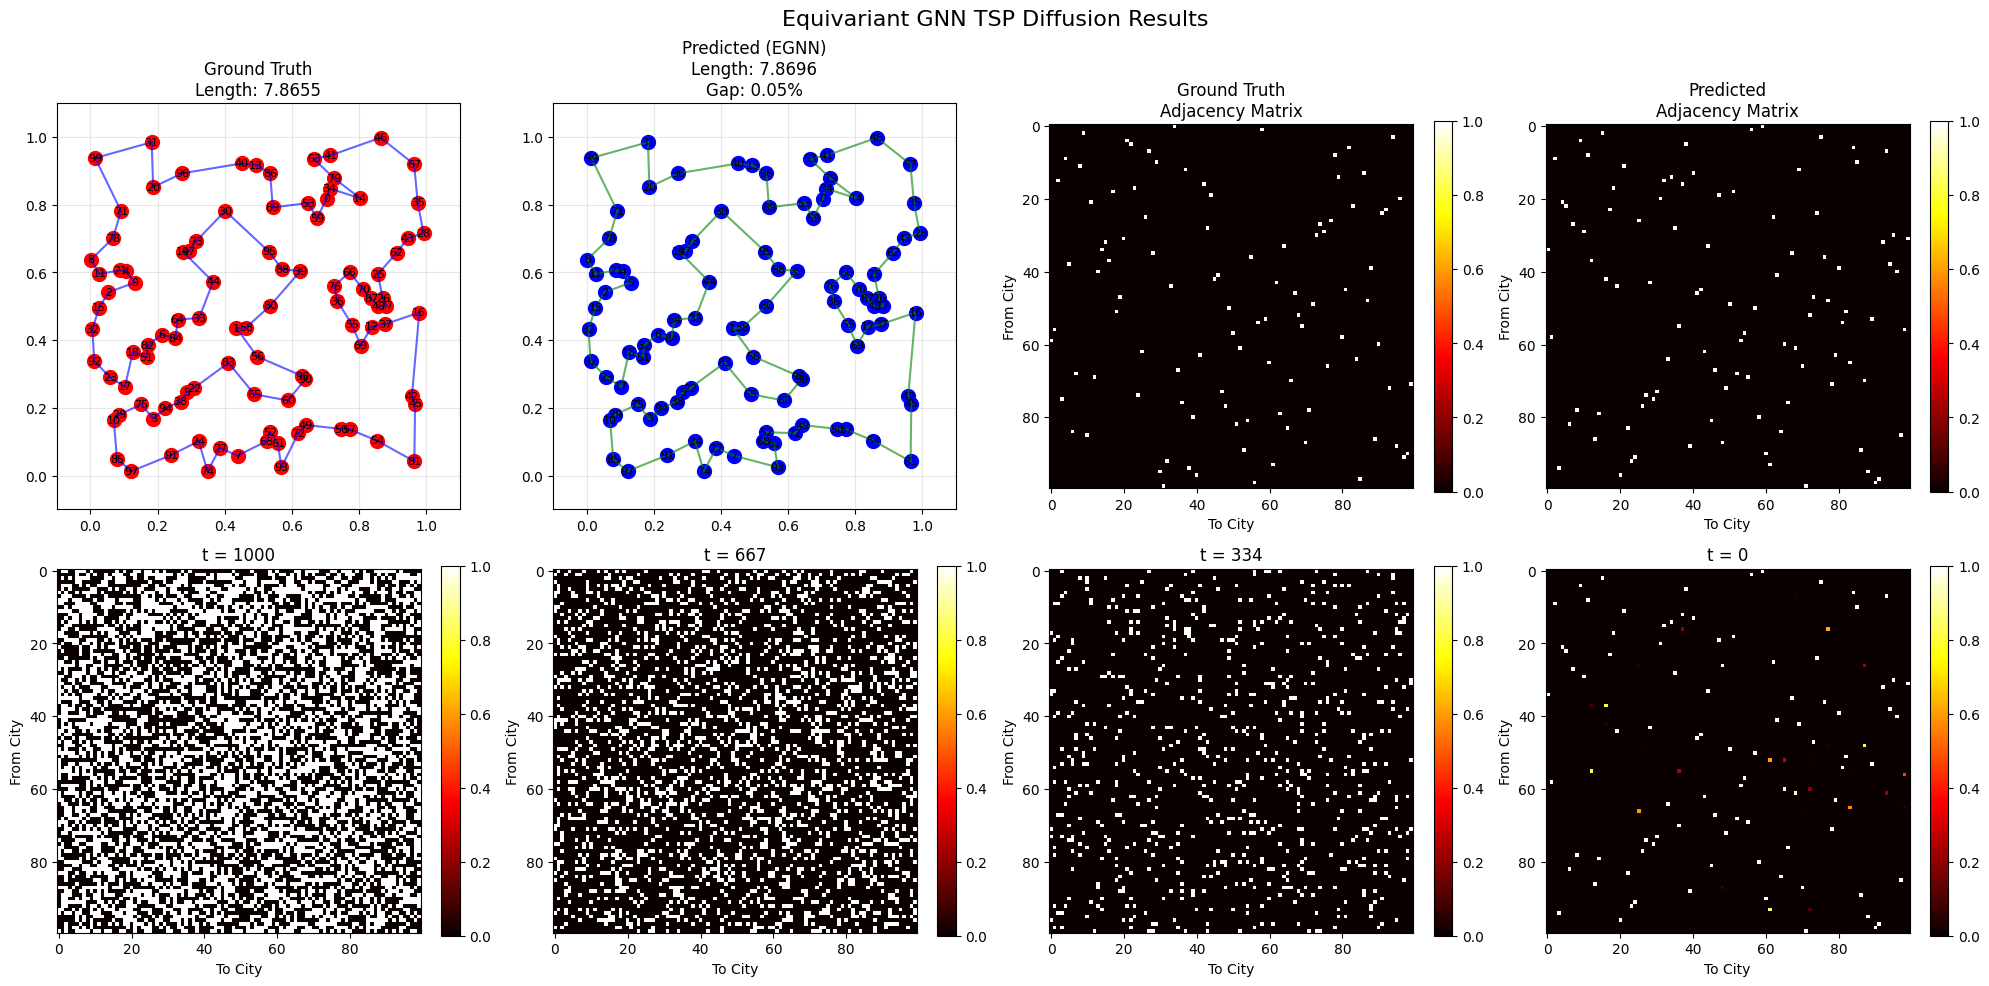


Visualization Results:
  Ground Truth Length: 7.8655
  Predicted Length: 7.8696
  Gap: 0.05%
  Predicted Tour: [0, 34, 14, 79, 63, 41, 46, 67, 35, 28, 43, 62, 25, 26, 77, 48, 87, 70, 66, 76, 36, 55, 69, 12, 37, 16, 42, 45, 81, 54, 57, 50, 49, 72, 52, 68, 61, 93, 7, 27, 74, 24, 91, 97, 85, 10, 29, 75, 3, 94, 38, 5, 22, 83, 65, 60, 90, 98, 56, 1, 58, 80, 39, 88, 95, 30, 73, 47, 19, 44, 33, 64, 84, 6, 82, 51, 18, 17, 23, 92, 32, 15, 2, 9, 4, 21, 11, 8, 78, 71, 99, 31, 20, 96, 40, 13, 86, 89, 53, 59]
  Ground Truth Tour: [0, 34, 14, 79, 63, 41, 46, 67, 35, 28, 43, 62, 25, 26, 77, 48, 87, 70, 66, 76, 36, 55, 69, 12, 37, 16, 42, 45, 81, 54, 57, 50, 49, 72, 93, 61, 52, 68, 7, 27, 74, 24, 91, 97, 85, 10, 29, 75, 3, 94, 38, 5, 22, 83, 65, 60, 90, 98, 56, 1, 58, 80, 39, 88, 95, 30, 73, 47, 19, 44, 33, 64, 84, 6, 82, 51, 18, 17, 23, 92, 32, 15, 2, 9, 4, 21, 11, 8, 78, 71, 99, 31, 20, 96, 40, 13, 86, 89, 53, 59]

Final Evaluation with Best/Worst Analysis:


Evaluating: 100%|██████████| 4/4 [00:32<00:00,  8.17s/it]


Average Gap: 2.59% ± 7.53%
Min Gap: 0.00%
Max Gap: 34.63%

Generating best/worst instance comparison...


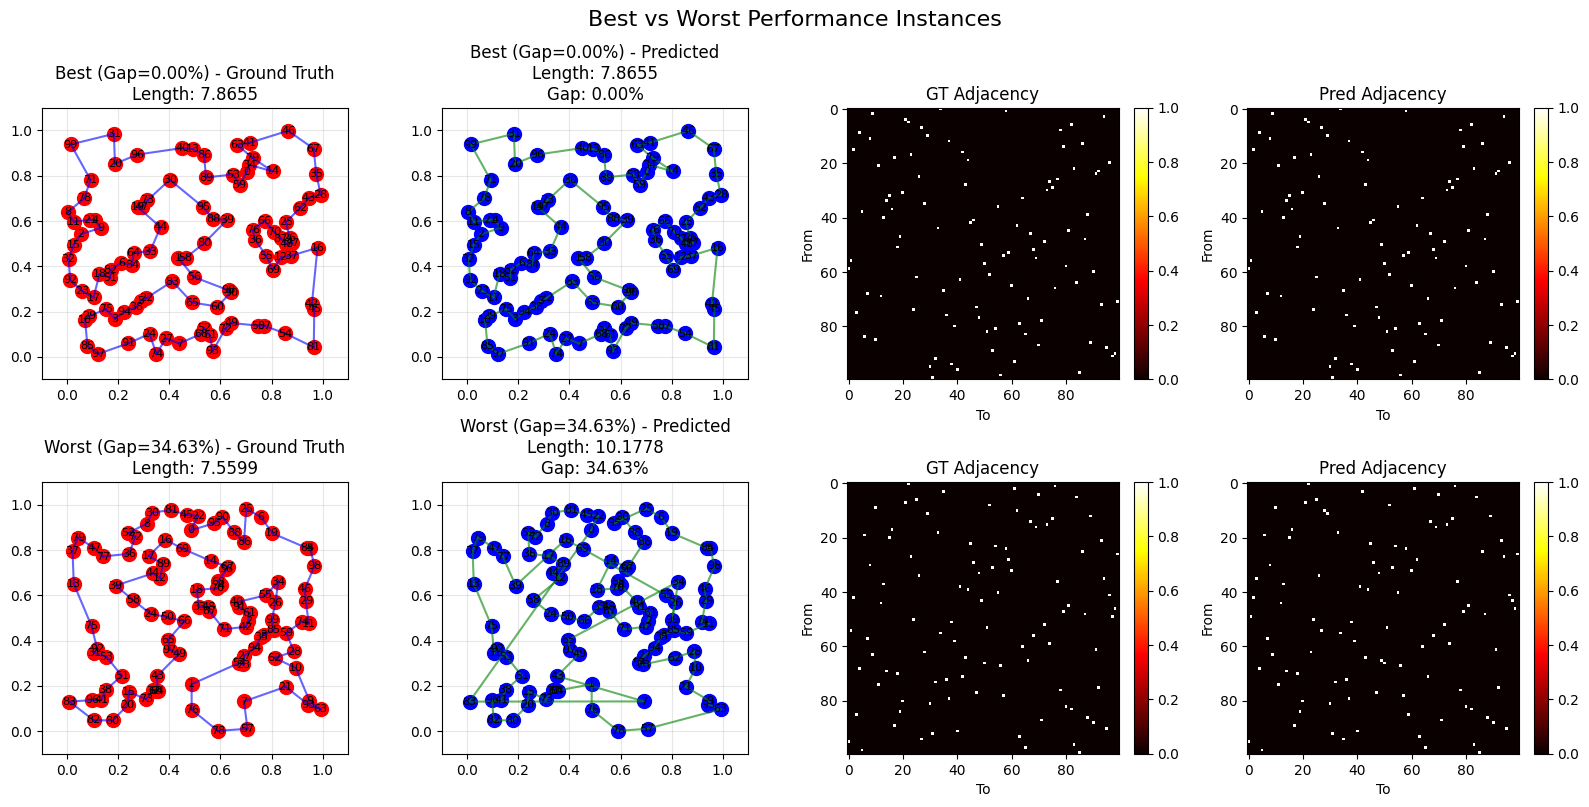


Best and Worst Instance Analysis:
------------------------------------------------------------
Best Instance (Index 0):
  Gap: 0.00%
  Predicted Length: 7.8655
  Ground Truth Length: 7.8655
  Tour: [0, 34, 14, 79, 63, 41, 46, 67, 35, 28, 43, 62, 25, 26, 77, 48, 87, 70, 66, 76, 36, 55, 69, 12, 37, 16, 42, 45, 81, 54, 57, 50, 49, 72, 93, 61, 52, 68, 7, 27, 74, 24, 91, 97, 85, 10, 29, 75, 3, 94, 38, 5, 22, 83, 65, 60, 90, 98, 56, 1, 58, 80, 39, 88, 95, 30, 73, 47, 19, 44, 33, 64, 84, 6, 82, 51, 18, 17, 23, 92, 32, 15, 2, 9, 4, 21, 11, 8, 78, 71, 99, 31, 20, 96, 40, 13, 86, 89, 53, 59]
------------------------------------------------------------
Worst Instance (Index 85):
  Gap: 34.63%
  Predicted Length: 10.1778
  Ground Truth Length: 7.5599
  Tour: [0, 22, 45, 81, 30, 8, 72, 52, 36, 17, 89, 44, 12, 58, 24, 50, 66, 33, 48, 87, 71, 42, 2, 61, 91, 40, 4, 68, 70, 18, 14, 67, 56, 86, 88, 90, 95, 25, 6, 19, 84, 5, 98, 46, 29, 74, 11, 59, 85, 3, 35, 94, 27, 54, 23, 62, 28, 10, 21, 9, 93, 63, 5

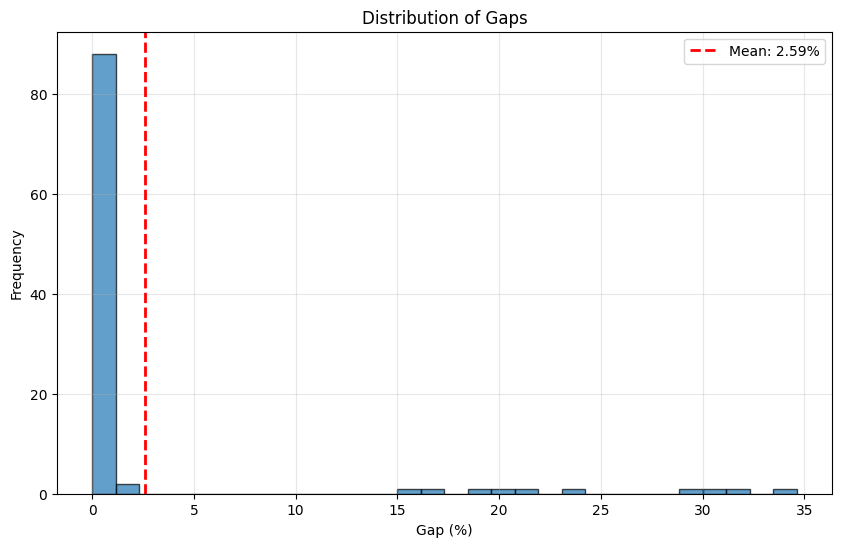

In [3]:
import os

# Load dataset first
# dataset = TSPDataset('tsp50_ortools.txt', n_instances=10000)
dataset = TSPDataset('tsp100_lkh.txt', n_instances=10000)
# Initialize model with same architecture
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = DiffusionTSPSolver(
    n_cities=dataset.n_cities,
    n_layers=8,
    hidden_dim=128,
    T=1000
).to(device)

# Load saved weights
checkpoint_path = './checkpoints/egnn_tsp100_best.pth'
if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    print(f"Successfully loaded model from {checkpoint_path}")
else:
    print(f"Warning: {checkpoint_path} not found!")

model.eval()

# Create validation split
val_size = 100
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

batch_size = 32
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Visualize results on a single instance
print("\nGenerating single instance visualization...")
visualize_results(model, val_dataset, device, idx=0)
    
# Final evaluation with best/worst tracking
print("\nFinal Evaluation with Best/Worst Analysis:")
final_results = evaluate(model, val_loader, device)
print(f"Average Gap: {final_results['avg_gap']:.2f}% ± {final_results['std_gap']:.2f}%")
print(f"Min Gap: {final_results['min_gap']:.2f}%")
print(f"Max Gap: {final_results['max_gap']:.2f}%")
    
# Visualize best and worst instances
print("\nGenerating best/worst instance comparison...")
visualize_best_worst(model, final_results, device)
    
# Optional: Show gap distribution
gaps = [r['gap'] for r in final_results['all_results']]
plt.figure(figsize=(10, 6))
plt.hist(gaps, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(final_results['avg_gap'], color='red', linestyle='--', linewidth=2, label=f'Mean: {final_results["avg_gap"]:.2f}%')
plt.xlabel('Gap (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Gaps')
plt.legend()
plt.grid(True, alpha=0.3)
# plt.savefig('gap_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

Loading 10000 TSP instances from tsp100_lkh.txt
Loaded 10000 instances with 100 cities
Successfully loaded model from ./checkpoints/egnn_tsp100_best.pth

EVALUATION WITH 16x SAMPLING (GREEDY SELECTION)


Evaluating with 16x sampling: 100%|██████████| 4/4 [10:02<00:00, 150.70s/it]



--- Single Sampling Results ---
Average Gap: 4.40% ± 10.01%
Min Gap: 0.00%
Max Gap: 38.44%

--- 16x Sampling Results (Best of 16) ---
Average Gap: 0.04% ± 0.08%
Min Gap: 0.00%
Max Gap: 0.60%

--- Improvement from Multi-Sampling ---
Average Improvement: 4.36%
Best Instance Gap: 0.00%
Worst Instance Gap: 0.60%
Most Improved Instance: 38.44%

Generating visualization...


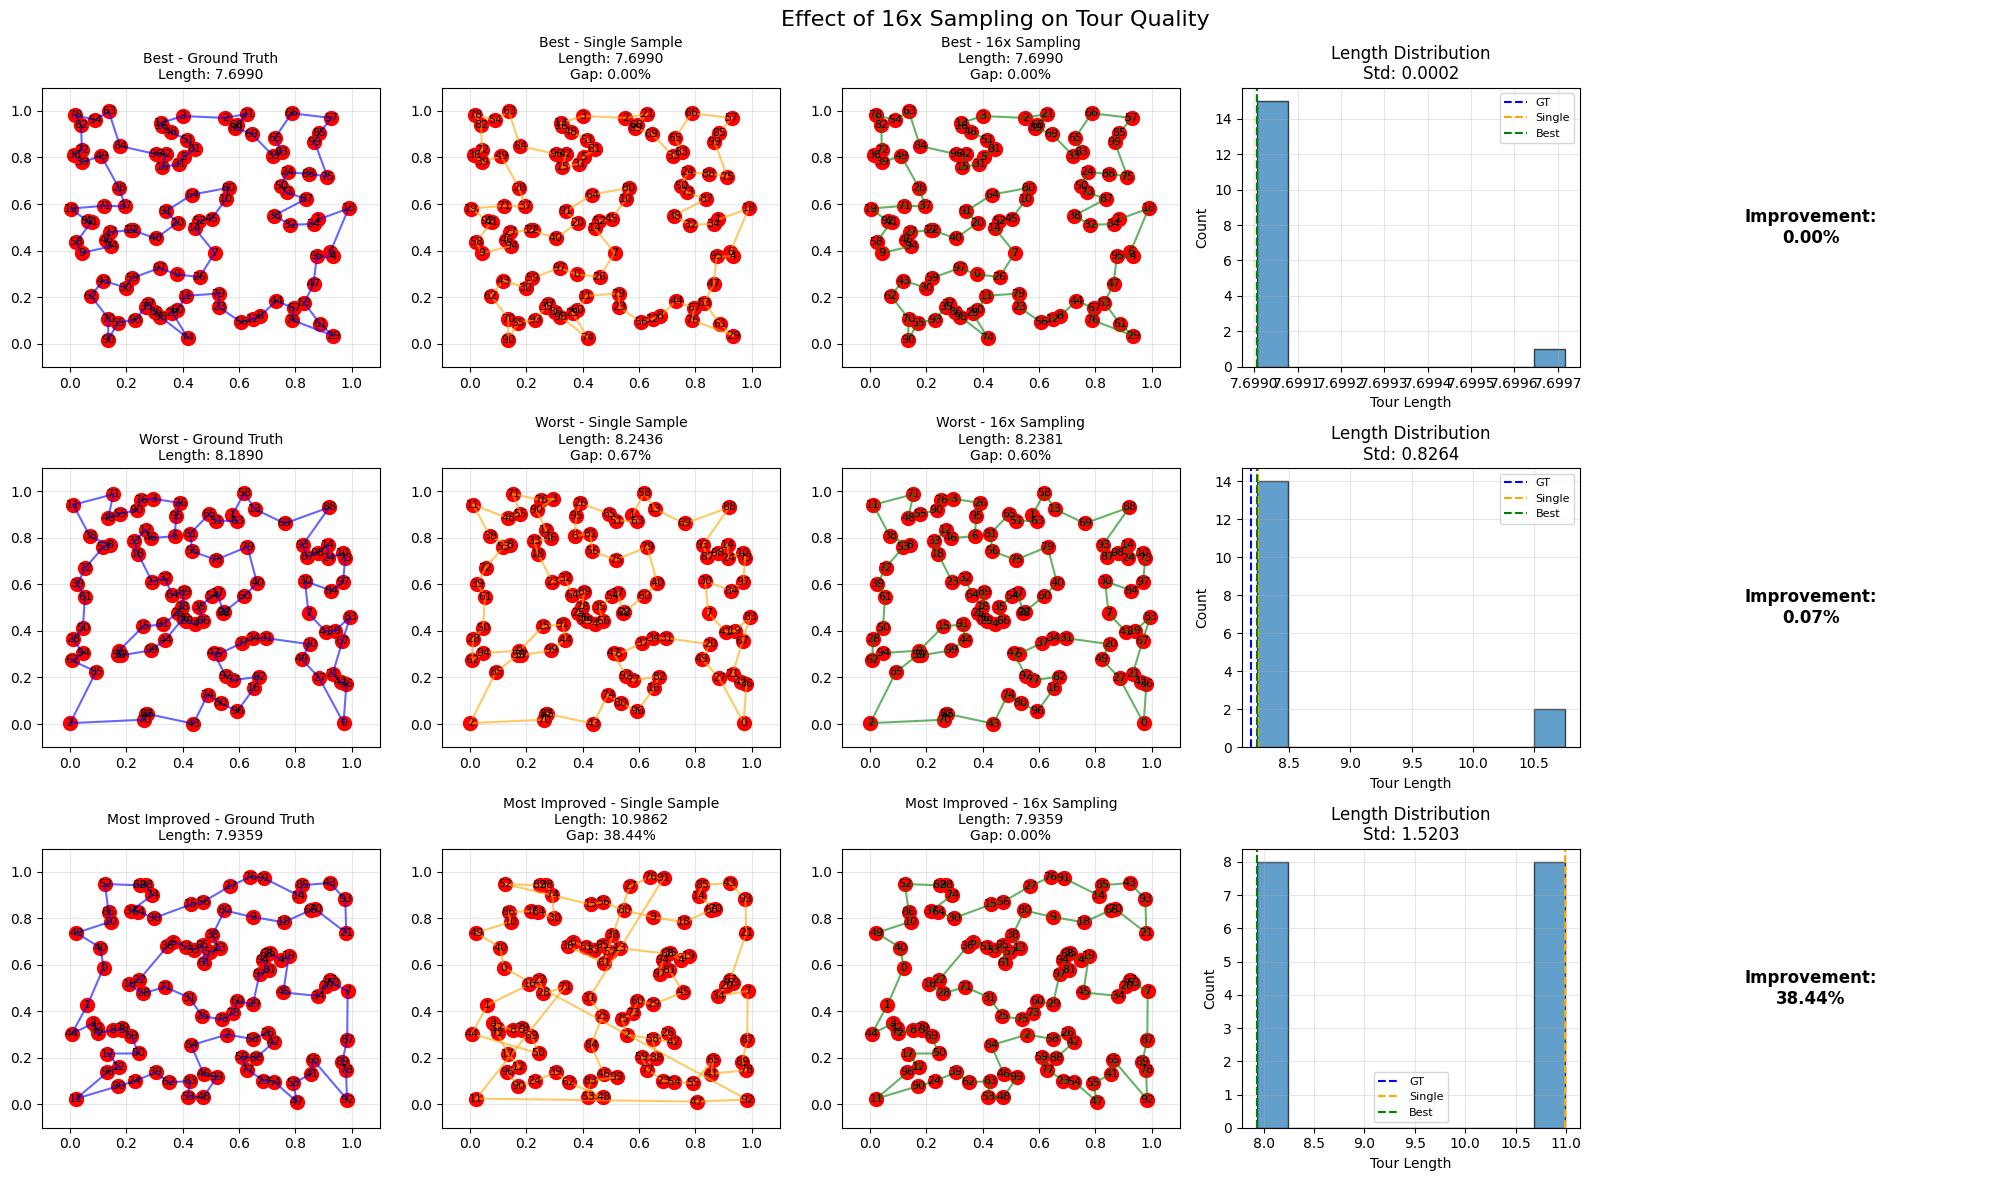


Generating detailed analysis...


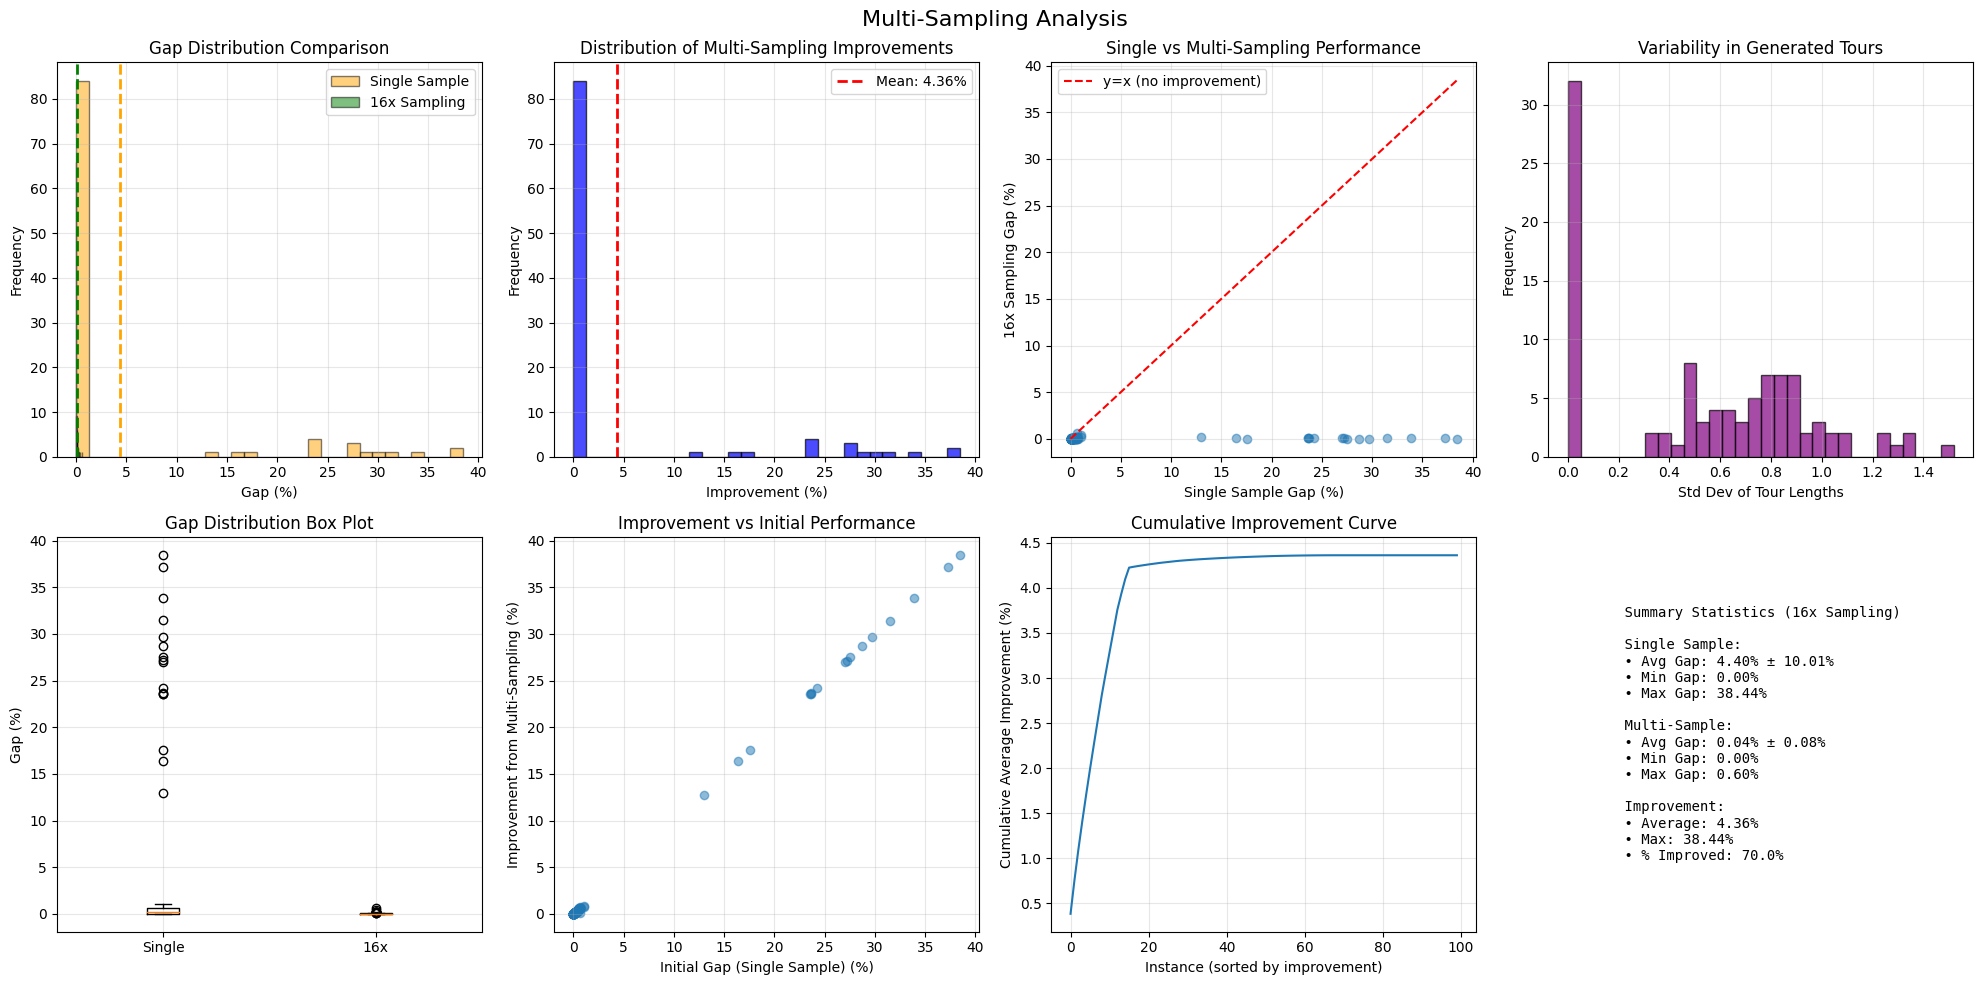


TESTING DIFFERENT SAMPLING NUMBERS


TypeError: list indices must be integers or slices, not list

In [7]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import math

# ============================================================================
# MULTI-SAMPLING EVALUATION
# ============================================================================

def evaluate_with_multisampling(model, dataloader, device, n_samples=16, use_2opt=False):
    """
    Evaluate model with multiple sampling (generate n_samples and pick the best).
    
    Args:
        model: The diffusion model
        dataloader: Data loader for validation set
        device: Device to run on
        n_samples: Number of samples to generate per instance
        use_2opt: Whether to apply 2-opt post-processing
    """
    model.eval()
    
    # Store results for different sampling strategies
    gaps_single = []
    gaps_multi = []
    gaps_single_2opt = []
    gaps_multi_2opt = []
    all_results = []
    
    with torch.no_grad():
        for batch_idx, (coords, adj_matrix, tour_gt) in enumerate(tqdm(dataloader, 
                                                                       desc=f"Evaluating with {n_samples}x sampling")):
            batch_size = coords.shape[0]
            coords = coords.to(device)
            
            # For each instance in the batch, generate multiple samples
            for b in range(batch_size):
                coords_single = coords[b:b+1]  # Keep batch dimension
                coords_cpu = coords[b].cpu()
                gt_tour = tour_gt[b].cpu()
                gt_length = compute_tour_length(coords_cpu, gt_tour)
                
                # Generate n_samples for this instance
                all_tours = []
                all_lengths = []
                all_lengths_2opt = []
                all_tours_2opt = []
                
                for sample_idx in range(n_samples):
                    # Generate a single sample with different random seed
                    tours, edge_probs = model.sample(coords_single, n_steps=50, device=device)
                    tour = tours[0]  # Get the single tour from batch
                    
                    # Calculate tour length
                    length = compute_tour_length(coords_cpu, tour)
                    all_tours.append(tour)
                    all_lengths.append(length)
                    
                    # Apply 2-opt if requested
                    if use_2opt:
                        tour_2opt, length_2opt = apply_2opt(coords_cpu, tour)
                        all_tours_2opt.append(tour_2opt)
                        all_lengths_2opt.append(length_2opt)
                
                # Find best tour among all samples (greedy selection)
                best_idx = np.argmin(all_lengths)
                best_tour = all_tours[best_idx]
                best_length = all_lengths[best_idx]
                
                # Single sample results (first sample only)
                single_tour = all_tours[0]
                single_length = all_lengths[0]
                gap_single = (single_length - gt_length) / gt_length * 100
                gaps_single.append(gap_single)
                
                # Multi-sample results (best of n_samples)
                gap_multi = (best_length - gt_length) / gt_length * 100
                gaps_multi.append(gap_multi)
                
                # With 2-opt results
                if use_2opt:
                    # Single sample with 2-opt
                    single_length_2opt = all_lengths_2opt[0]
                    gap_single_2opt = (single_length_2opt - gt_length) / gt_length * 100
                    gaps_single_2opt.append(gap_single_2opt)
                    
                    # Multi-sample with 2-opt (best of n_samples after 2-opt)
                    best_idx_2opt = np.argmin(all_lengths_2opt)
                    best_tour_2opt = all_tours_2opt[best_idx_2opt]
                    best_length_2opt = all_lengths_2opt[best_idx_2opt]
                    gap_multi_2opt = (best_length_2opt - gt_length) / gt_length * 100
                    gaps_multi_2opt.append(gap_multi_2opt)
                else:
                    gap_single_2opt = gap_single
                    gap_multi_2opt = gap_multi
                    best_tour_2opt = best_tour
                    best_length_2opt = best_length
                
                # Store detailed results
                all_results.append({
                    'coords': coords_cpu,
                    'gt_tour': gt_tour,
                    'gt_length': gt_length,
                    # Single sampling
                    'single_tour': single_tour,
                    'single_length': single_length,
                    'gap_single': gap_single,
                    'gap_single_2opt': gap_single_2opt,
                    # Multi sampling
                    'best_tour': best_tour,
                    'best_length': best_length,
                    'gap_multi': gap_multi,
                    'gap_multi_2opt': gap_multi_2opt,
                    'best_tour_2opt': best_tour_2opt,
                    'best_length_2opt': best_length_2opt,
                    # Statistics
                    'all_lengths': all_lengths,
                    'improvement_multisampling': gap_single - gap_multi,
                    'improvement_2opt': gap_multi - gap_multi_2opt if use_2opt else 0,
                    'n_samples': n_samples,
                    'length_std': np.std(all_lengths),
                    'length_min': np.min(all_lengths),
                    'length_max': np.max(all_lengths),
                    'global_idx': batch_idx * batch_size + b
                })
    
    # Find best and worst instances based on multi-sampling gaps
    sorted_results = sorted(all_results, key=lambda x: x['gap_multi'])
    best_instance = sorted_results[0]
    worst_instance = sorted_results[-1]
    
    # Find instance with most improvement from multi-sampling
    most_improved_multi = max(all_results, key=lambda x: x['improvement_multisampling'])
    
    return {
        # Single sampling statistics
        'avg_gap_single': np.mean(gaps_single),
        'std_gap_single': np.std(gaps_single),
        'min_gap_single': np.min(gaps_single),
        'max_gap_single': np.max(gaps_single),
        # Multi sampling statistics
        'avg_gap_multi': np.mean(gaps_multi),
        'std_gap_multi': np.std(gaps_multi),
        'min_gap_multi': np.min(gaps_multi),
        'max_gap_multi': np.max(gaps_multi),
        # With 2-opt statistics
        'avg_gap_single_2opt': np.mean(gaps_single_2opt) if use_2opt else None,
        'avg_gap_multi_2opt': np.mean(gaps_multi_2opt) if use_2opt else None,
        # Improvements
        'avg_improvement_multisampling': np.mean([r['improvement_multisampling'] for r in all_results]),
        'avg_improvement_2opt': np.mean([r['improvement_2opt'] for r in all_results]) if use_2opt else None,
        # Instance analysis
        'best_instance': best_instance,
        'worst_instance': worst_instance,
        'most_improved_multi': most_improved_multi,
        'all_results': all_results,
        'n_samples': n_samples
    }


def visualize_multisampling_results(eval_results):
    """Visualize the effect of multi-sampling"""
    
    fig = plt.figure(figsize=(20, 12))
    
    # Helper function to plot tour
    def plot_tour(ax, coords, tour, title, color='b'):
        coords_np = coords.numpy() if torch.is_tensor(coords) else coords
        tour_np = tour.numpy() if torch.is_tensor(tour) else tour
        
        ax.scatter(coords_np[:, 0], coords_np[:, 1], c='red', s=100, zorder=2)
        n_cities = len(coords_np)
        for i in range(n_cities):
            ax.text(coords_np[i, 0], coords_np[i, 1], str(i), fontsize=8, ha='center', va='center')
        
        for i in range(len(tour_np)):
            start = coords_np[tour_np[i]]
            end = coords_np[tour_np[(i + 1) % len(tour_np)]]
            ax.plot([start[0], end[0]], [start[1], end[1]], color=color, alpha=0.6)
        
        ax.set_title(title, fontsize=10)
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, 1.1)
        ax.grid(True, alpha=0.3)
    
    # Get instances to visualize
    best = eval_results['best_instance']
    worst = eval_results['worst_instance']
    most_improved = eval_results['most_improved_multi']
    
    # Row 1: Best instance
    ax1 = plt.subplot(3, 5, 1)
    plot_tour(ax1, best['coords'], best['gt_tour'], 
              f'Best - Ground Truth\nLength: {best["gt_length"]:.4f}', 'b')
    
    ax2 = plt.subplot(3, 5, 2)
    plot_tour(ax2, best['coords'], best['single_tour'], 
              f'Best - Single Sample\nLength: {best["single_length"]:.4f}\nGap: {best["gap_single"]:.2f}%', 'orange')
    
    ax3 = plt.subplot(3, 5, 3)
    plot_tour(ax3, best['coords'], best['best_tour'], 
              f'Best - {best["n_samples"]}x Sampling\nLength: {best["best_length"]:.4f}\nGap: {best["gap_multi"]:.2f}%', 'g')
    
    # Length distribution for best instance
    ax4 = plt.subplot(3, 5, 4)
    ax4.hist(best['all_lengths'], bins=10, edgecolor='black', alpha=0.7)
    ax4.axvline(best['gt_length'], color='blue', linestyle='--', label='GT')
    ax4.axvline(best['single_length'], color='orange', linestyle='--', label='Single')
    ax4.axvline(best['best_length'], color='green', linestyle='--', label='Best')
    ax4.set_xlabel('Tour Length')
    ax4.set_ylabel('Count')
    ax4.set_title(f'Length Distribution\nStd: {best["length_std"]:.4f}')
    ax4.legend(fontsize=8)
    ax4.grid(True, alpha=0.3)
    
    ax5 = plt.subplot(3, 5, 5)
    ax5.text(0.5, 0.5, f'Improvement:\n{best["improvement_multisampling"]:.2f}%', 
             ha='center', va='center', fontsize=12, weight='bold')
    ax5.set_xlim(0, 1)
    ax5.set_ylim(0, 1)
    ax5.axis('off')
    
    # Row 2: Worst instance
    ax6 = plt.subplot(3, 5, 6)
    plot_tour(ax6, worst['coords'], worst['gt_tour'], 
              f'Worst - Ground Truth\nLength: {worst["gt_length"]:.4f}', 'b')
    
    ax7 = plt.subplot(3, 5, 7)
    plot_tour(ax7, worst['coords'], worst['single_tour'], 
              f'Worst - Single Sample\nLength: {worst["single_length"]:.4f}\nGap: {worst["gap_single"]:.2f}%', 'orange')
    
    ax8 = plt.subplot(3, 5, 8)
    plot_tour(ax8, worst['coords'], worst['best_tour'], 
              f'Worst - {worst["n_samples"]}x Sampling\nLength: {worst["best_length"]:.4f}\nGap: {worst["gap_multi"]:.2f}%', 'g')
    
    ax9 = plt.subplot(3, 5, 9)
    ax9.hist(worst['all_lengths'], bins=10, edgecolor='black', alpha=0.7)
    ax9.axvline(worst['gt_length'], color='blue', linestyle='--', label='GT')
    ax9.axvline(worst['single_length'], color='orange', linestyle='--', label='Single')
    ax9.axvline(worst['best_length'], color='green', linestyle='--', label='Best')
    ax9.set_xlabel('Tour Length')
    ax9.set_ylabel('Count')
    ax9.set_title(f'Length Distribution\nStd: {worst["length_std"]:.4f}')
    ax9.legend(fontsize=8)
    ax9.grid(True, alpha=0.3)
    
    ax10 = plt.subplot(3, 5, 10)
    ax10.text(0.5, 0.5, f'Improvement:\n{worst["improvement_multisampling"]:.2f}%', 
              ha='center', va='center', fontsize=12, weight='bold')
    ax10.set_xlim(0, 1)
    ax10.set_ylim(0, 1)
    ax10.axis('off')
    
    # Row 3: Most improved instance
    ax11 = plt.subplot(3, 5, 11)
    plot_tour(ax11, most_improved['coords'], most_improved['gt_tour'], 
              f'Most Improved - Ground Truth\nLength: {most_improved["gt_length"]:.4f}', 'b')
    
    ax12 = plt.subplot(3, 5, 12)
    plot_tour(ax12, most_improved['coords'], most_improved['single_tour'], 
              f'Most Improved - Single Sample\nLength: {most_improved["single_length"]:.4f}\nGap: {most_improved["gap_single"]:.2f}%', 'orange')
    
    ax13 = plt.subplot(3, 5, 13)
    plot_tour(ax13, most_improved['coords'], most_improved['best_tour'], 
              f'Most Improved - {most_improved["n_samples"]}x Sampling\nLength: {most_improved["best_length"]:.4f}\nGap: {most_improved["gap_multi"]:.2f}%', 'g')
    
    ax14 = plt.subplot(3, 5, 14)
    ax14.hist(most_improved['all_lengths'], bins=10, edgecolor='black', alpha=0.7)
    ax14.axvline(most_improved['gt_length'], color='blue', linestyle='--', label='GT')
    ax14.axvline(most_improved['single_length'], color='orange', linestyle='--', label='Single')
    ax14.axvline(most_improved['best_length'], color='green', linestyle='--', label='Best')
    ax14.set_xlabel('Tour Length')
    ax14.set_ylabel('Count')
    ax14.set_title(f'Length Distribution\nStd: {most_improved["length_std"]:.4f}')
    ax14.legend(fontsize=8)
    ax14.grid(True, alpha=0.3)
    
    ax15 = plt.subplot(3, 5, 15)
    ax15.text(0.5, 0.5, f'Improvement:\n{most_improved["improvement_multisampling"]:.2f}%', 
              ha='center', va='center', fontsize=12, weight='bold')
    ax15.set_xlim(0, 1)
    ax15.set_ylim(0, 1)
    ax15.axis('off')
    
    plt.suptitle(f'Effect of {eval_results["n_samples"]}x Sampling on Tour Quality', fontsize=16)
    plt.tight_layout()
    plt.show()


def plot_sampling_analysis(eval_results):
    """Create detailed analysis plots for multi-sampling"""
    
    fig = plt.figure(figsize=(20, 10))
    
    # Extract data
    gaps_single = [r['gap_single'] for r in eval_results['all_results']]
    gaps_multi = [r['gap_multi'] for r in eval_results['all_results']]
    improvements = [r['improvement_multisampling'] for r in eval_results['all_results']]
    length_stds = [r['length_std'] for r in eval_results['all_results']]
    
    # Plot 1: Gap distribution comparison
    ax1 = plt.subplot(2, 4, 1)
    ax1.hist(gaps_single, bins=30, alpha=0.5, label='Single Sample', color='orange', edgecolor='black')
    ax1.hist(gaps_multi, bins=30, alpha=0.5, label=f'{eval_results["n_samples"]}x Sampling', color='green', edgecolor='black')
    ax1.axvline(eval_results['avg_gap_single'], color='orange', linestyle='--', linewidth=2)
    ax1.axvline(eval_results['avg_gap_multi'], color='green', linestyle='--', linewidth=2)
    ax1.set_xlabel('Gap (%)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Gap Distribution Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Improvement distribution
    ax2 = plt.subplot(2, 4, 2)
    ax2.hist(improvements, bins=30, color='blue', alpha=0.7, edgecolor='black')
    ax2.axvline(eval_results['avg_improvement_multisampling'], color='red', linestyle='--', linewidth=2,
                label=f'Mean: {eval_results["avg_improvement_multisampling"]:.2f}%')
    ax2.set_xlabel('Improvement (%)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Multi-Sampling Improvements')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Scatter plot of single vs multi gaps
    ax3 = plt.subplot(2, 4, 3)
    ax3.scatter(gaps_single, gaps_multi, alpha=0.5)
    ax3.plot([min(gaps_single), max(gaps_single)], [min(gaps_single), max(gaps_single)], 
             'r--', label='y=x (no improvement)')
    ax3.set_xlabel('Single Sample Gap (%)')
    ax3.set_ylabel(f'{eval_results["n_samples"]}x Sampling Gap (%)')
    ax3.set_title('Single vs Multi-Sampling Performance')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Length standard deviation distribution
    ax4 = plt.subplot(2, 4, 4)
    ax4.hist(length_stds, bins=30, color='purple', alpha=0.7, edgecolor='black')
    ax4.set_xlabel('Std Dev of Tour Lengths')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Variability in Generated Tours')
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: Box plot comparison
    ax5 = plt.subplot(2, 4, 5)
    ax5.boxplot([gaps_single, gaps_multi], labels=['Single', f'{eval_results["n_samples"]}x'])
    ax5.set_ylabel('Gap (%)')
    ax5.set_title('Gap Distribution Box Plot')
    ax5.grid(True, alpha=0.3)
    
    # Plot 6: Improvement vs initial gap
    ax6 = plt.subplot(2, 4, 6)
    ax6.scatter(gaps_single, improvements, alpha=0.5)
    ax6.set_xlabel('Initial Gap (Single Sample) (%)')
    ax6.set_ylabel('Improvement from Multi-Sampling (%)')
    ax6.set_title('Improvement vs Initial Performance')
    ax6.grid(True, alpha=0.3)
    
    # Plot 7: Cumulative improvement
    ax7 = plt.subplot(2, 4, 7)
    sorted_improvements = sorted(improvements, reverse=True)
    cumulative = np.cumsum(sorted_improvements) / len(sorted_improvements)
    ax7.plot(range(len(cumulative)), cumulative)
    ax7.set_xlabel('Instance (sorted by improvement)')
    ax7.set_ylabel('Cumulative Average Improvement (%)')
    ax7.set_title('Cumulative Improvement Curve')
    ax7.grid(True, alpha=0.3)
    
    # Plot 8: Summary statistics
    ax8 = plt.subplot(2, 4, 8)
    ax8.axis('off')
    stats_text = f"""
    Summary Statistics ({eval_results['n_samples']}x Sampling)
    
    Single Sample:
    • Avg Gap: {eval_results['avg_gap_single']:.2f}% ± {eval_results['std_gap_single']:.2f}%
    • Min Gap: {eval_results['min_gap_single']:.2f}%
    • Max Gap: {eval_results['max_gap_single']:.2f}%
    
    Multi-Sample:
    • Avg Gap: {eval_results['avg_gap_multi']:.2f}% ± {eval_results['std_gap_multi']:.2f}%
    • Min Gap: {eval_results['min_gap_multi']:.2f}%
    • Max Gap: {eval_results['max_gap_multi']:.2f}%
    
    Improvement:
    • Average: {eval_results['avg_improvement_multisampling']:.2f}%
    • Max: {max(improvements):.2f}%
    • % Improved: {sum([i > 0 for i in improvements]) / len(improvements) * 100:.1f}%
    """
    ax8.text(0.1, 0.5, stats_text, fontsize=10, verticalalignment='center', family='monospace')
    
    plt.suptitle('Multi-Sampling Analysis', fontsize=16)
    plt.tight_layout()
    plt.show()


# Main execution code
if __name__ == "__main__":
    # Load dataset
    dataset = TSPDataset('tsp100_lkh.txt', n_instances=10000)
    
    # Initialize model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = DiffusionTSPSolver(
        n_cities=dataset.n_cities,
        n_layers=8,
        hidden_dim=128,
        T=1000
    ).to(device)
    
    # Load saved weights
    checkpoint_path = './checkpoints/egnn_tsp100_best.pth'
    if os.path.exists(checkpoint_path):
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        print(f"Successfully loaded model from {checkpoint_path}")
    else:
        print(f"Warning: {checkpoint_path} not found!")
    
    model.eval()
    
    # Create validation split
    val_size = 100
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    batch_size = 32
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # ============================================================================
    # EVALUATION WITH 16x SAMPLING (GREEDY ONLY)
    # ============================================================================
    
    print("\n" + "="*80)
    print("EVALUATION WITH 16x SAMPLING (GREEDY SELECTION)")
    print("="*80)
    
    # Run evaluation with 16x sampling
    eval_results_16x = evaluate_with_multisampling(
        model, val_loader, device, n_samples=16, use_2opt=False
    )
    
    print("\n--- Single Sampling Results ---")
    print(f"Average Gap: {eval_results_16x['avg_gap_single']:.2f}% ± {eval_results_16x['std_gap_single']:.2f}%")
    print(f"Min Gap: {eval_results_16x['min_gap_single']:.2f}%")
    print(f"Max Gap: {eval_results_16x['max_gap_single']:.2f}%")
    
    print("\n--- 16x Sampling Results (Best of 16) ---")
    print(f"Average Gap: {eval_results_16x['avg_gap_multi']:.2f}% ± {eval_results_16x['std_gap_multi']:.2f}%")
    print(f"Min Gap: {eval_results_16x['min_gap_multi']:.2f}%")
    print(f"Max Gap: {eval_results_16x['max_gap_multi']:.2f}%")
    
    print(f"\n--- Improvement from Multi-Sampling ---")
    print(f"Average Improvement: {eval_results_16x['avg_improvement_multisampling']:.2f}%")
    print(f"Best Instance Gap: {eval_results_16x['best_instance']['gap_multi']:.2f}%")
    print(f"Worst Instance Gap: {eval_results_16x['worst_instance']['gap_multi']:.2f}%")
    print(f"Most Improved Instance: {eval_results_16x['most_improved_multi']['improvement_multisampling']:.2f}%")
    
    # Visualize results
    print("\nGenerating visualization...")
    visualize_multisampling_results(eval_results_16x)
    
    # Detailed analysis plots
    print("\nGenerating detailed analysis...")
    plot_sampling_analysis(eval_results_16x)
    
    # ============================================================================
    # OPTIONAL: COMPARISON WITH DIFFERENT SAMPLING NUMBERS
    # ============================================================================
    
    print("\n" + "="*80)
    print("TESTING DIFFERENT SAMPLING NUMBERS")
    print("="*80)
    
    sampling_numbers = [1, 2, 4, 8, 16, 32]
    avg_gaps = []
    
    # Use a smaller subset for this test
    small_loader = DataLoader(val_dataset[:10], batch_size=5, shuffle=False)
    
    for n_samples in sampling_numbers:
        print(f"\nTesting {n_samples}x sampling...")
        eval_temp = evaluate_with_multisampling(
            model, small_loader, device, n_samples=n_samples, use_2opt=False
        )
        avg_gaps.append(eval_temp['avg_gap_multi'])
        print(f"  Average Gap: {eval_temp['avg_gap_multi']:.2f}%")
    
    # Plot sampling effectiveness
    plt.figure(figsize=(10, 6))
    plt.plot(sampling_numbers, avg_gaps, 'b-o', linewidth=2, markersize=8)
    plt.xlabel('Number of Samples')
    plt.ylabel('Average Gap (%)')
    plt.title('Effect of Sample Size on Performance')
    plt.grid(True, alpha=0.3)
    plt.xscale('log', base=2)
    plt.xticks(sampling_numbers, [str(n) for n in sampling_numbers])
    plt.show()
    
    print("\n" + "="*80)
    print("EVALUATION COMPLETE!")
    print("="*80)

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import imageio
from PIL import Image
import io

# ============================================================================
# DIFFUSION PROCESS VISUALIZATION
# ============================================================================

def sample_with_history(model, coords, n_steps=50, device='cuda'):
    """
    Sample a tour using diffusion while saving intermediate states.
    """
    model.eval()
    batch_size = coords.shape[0]
    
    # Initialize with noise
    xt = torch.randint(0, 2, (batch_size, model.n_edges), device=device).float()
    
    # Cosine schedule for inference
    timesteps = torch.linspace(model.T - 1, 0, n_steps, device=device).long()
    
    # Store history
    history = {
        'xt': [],  # Noisy state
        'x0_probs': [],  # Predicted clean state
        'timesteps': []
    }
    
    # Store initial noisy state
    history['xt'].append(xt[0].cpu().numpy())
    history['timesteps'].append(model.T)
    
    with torch.no_grad():
        for i in range(len(timesteps) - 1):
            t = timesteps[i].repeat(batch_size)
            target_t = timesteps[i + 1].item()
            
            # Predict x0
            x0_logits = model.forward(coords, xt, t)
            x0_probs = F.softmax(x0_logits, dim=-1)
            
            # Store predictions
            history['x0_probs'].append(x0_probs[0, :, 1].cpu().numpy())
            history['timesteps'].append(t[0].item())
            
            # Sample from posterior
            if target_t > 0:
                xt = model.diffusion.posterior(xt, t[0].cpu().numpy(), x0_probs, target_t)
                xt = xt.to(device)
                history['xt'].append(xt[0].cpu().numpy())
            else:
                # Final step
                xt = x0_probs[..., 1]
                history['xt'].append(xt[0].cpu().numpy())
        
        # Final prediction
        x0_probs_final = xt if target_t == 0 else F.softmax(
            model.forward(coords, xt, torch.zeros(batch_size, device=device).long()), 
            dim=-1
        )[..., 1]
        
        # Store final state
        history['x0_probs'].append(x0_probs_final[0].cpu().numpy())
        history['timesteps'].append(0)
    
    # Decode tour
    edge_index_cpu = model.edge_index.cpu()
    tour = merge_tours(x0_probs_final[0].cpu(), coords[0].cpu(), edge_index_cpu)
    
    return tour, x0_probs_final[0].cpu().numpy(), history


def create_tour_frames(coords, history, model):
    """Create frames showing the tour evolution"""
    frames = []
    n_cities = len(coords)
    edge_index = model.edge_index.cpu().numpy()
    
    # Use Blues colormap to match adjacency matrix
    cmap = plt.cm.Blues
    
    for step_idx in range(len(history['x0_probs'])):
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        
        # Get current state
        timestep = history['timesteps'][step_idx + 1]
        
        # Use xt (noisy state) for early steps, x0_probs for later
        if step_idx < len(history['xt']) - 1:
            edge_state = history['xt'][step_idx]
        else:
            edge_state = history['x0_probs'][step_idx]
        
        # Plot nodes (smaller size)
        ax.scatter(coords[:, 0], coords[:, 1], c='#1f4788', s=30, zorder=3, 
                   edgecolor='white', linewidth=1, alpha=0.9)
        
        # Draw edges with probability-based thickness and color
        for i in range(len(edge_state)):
            u, v = edge_index[0, i], edge_index[1, i]
            prob = edge_state[i]
            
            if prob > 0.05:  # Show edges with reasonable probability
                alpha = np.clip(prob * 0.8, 0.1, 0.8)
                width = np.clip(prob * 3, 0.3, 3)
                # Use blue colormap for consistency
                color = cmap(0.2 + prob * 0.8)  # Map to blue range
                
                ax.plot([coords[u, 0], coords[v, 0]], 
                       [coords[u, 1], coords[v, 1]], 
                       color=color, alpha=alpha, linewidth=width, zorder=1)
        
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, 1.1)
        ax.set_title(f'Tour Evolution (t = {timestep})', fontsize=14, weight='bold')
        ax.set_xlabel('X', fontsize=12)
        ax.set_ylabel('Y', fontsize=12)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_aspect('equal')
        
        plt.tight_layout()
        
        # Convert to image
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=100, bbox_inches='tight', facecolor='white')
        buf.seek(0)
        img = Image.open(buf)
        frames.append(np.array(img))
        plt.close()
        
    return frames


def create_adjacency_frames(coords, history, model):
    """Create frames showing the adjacency matrix evolution"""
    frames = []
    n_cities = len(coords)
    edge_index = model.edge_index.cpu().numpy()
    
    # Use Blues colormap
    cmap = plt.cm.viridis
    
    for step_idx in range(len(history['x0_probs'])):
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        
        # Get current state
        timestep = history['timesteps'][step_idx + 1]
        
        # Get predicted clean state
        edge_probs = history['x0_probs'][step_idx]
        
        # Convert edge probabilities to adjacency matrix
        adj_matrix = np.zeros((n_cities, n_cities))
        
        for i in range(len(edge_probs)):
            u, v = edge_index[0, i], edge_index[1, i]
            adj_matrix[u, v] = edge_probs[i]
        
        # Plot adjacency matrix
        im = ax.imshow(adj_matrix, cmap=cmap, vmin=0, vmax=1, 
                      interpolation='nearest', aspect='equal')
        ax.set_title(f'Adjacency Matrix (t = {timestep})', fontsize=14, weight='bold')
        ax.set_xlabel('To City', fontsize=12)
        ax.set_ylabel('From City', fontsize=12)
        
        # Add colorbar
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        # Add subtle grid lines
        for i in range(n_cities + 1):
            ax.axhline(i - 0.5, color='gray', linewidth=0.3, alpha=0.3)
            ax.axvline(i - 0.5, color='gray', linewidth=0.3, alpha=0.3)
        
        plt.tight_layout()
        
        # Convert to image
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=100, bbox_inches='tight', facecolor='white')
        buf.seek(0)
        img = Image.open(buf)
        frames.append(np.array(img))
        plt.close()
        
    return frames


def find_best_instance(model, dataloader, device):
    """Find the instance with minimum gap"""
    model.eval()
    best_gap = float('inf')
    best_instance = None
    
    with torch.no_grad():
        for coords, adj_matrix, tour_gt in tqdm(dataloader, desc="Finding best instance"):
            coords = coords.to(device)
            
            # Generate tours
            tours, edge_probs = model.sample(coords, n_steps=50, device=device)
            
            # Calculate gaps
            for b in range(coords.shape[0]):
                pred_tour = tours[b]
                pred_length = compute_tour_length(coords[b].cpu(), pred_tour)
                gt_length = compute_tour_length(coords[b].cpu(), tour_gt[b])
                gap = (pred_length - gt_length) / gt_length * 100
                
                if gap < best_gap:
                    best_gap = gap
                    best_instance = {
                        'coords': coords[b].cpu(),
                        'adj_matrix': adj_matrix[b].cpu(),
                        'tour_gt': tour_gt[b].cpu(),
                        'pred_tour': pred_tour,
                        'gap': gap
                    }
    
    return best_instance




In [3]:
# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    # Load dataset
    dataset = TSPDataset('tsp50_ortools.txt', n_instances=10000)
    
    # Initialize model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = DiffusionTSPSolver(
        n_cities=dataset.n_cities,
        n_layers=8,
        hidden_dim=128,
        T=1000
    ).to(device)
    
    # Load saved weights
    checkpoint_path = './checkpoints/egnn_tsp50_best.pth'
    if os.path.exists(checkpoint_path):
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        print(f"Successfully loaded model from {checkpoint_path}")
    else:
        print(f"Warning: {checkpoint_path} not found!")
    
    model.eval()
    
    # Create validation split
    val_size = 100
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    batch_size = 32
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    print("\nFinding best instance (minimum gap)...")
    best_instance = find_best_instance(model, val_loader, device)
    print(f"Best instance found with gap: {best_instance['gap']:.2f}%")
    
    print("\nGenerating diffusion process visualization...")
    
    # Generate solution with history for the best instance
    coords = best_instance['coords'].unsqueeze(0).to(device)
    tour, edge_probs, history = sample_with_history(model, coords, n_steps=50, device=device)
    
    print(f"Generated {len(history['x0_probs'])} frames")
    print(f"Timesteps: {history['timesteps'][0]} → {history['timesteps'][-1]}")
    
    

Loading 10000 TSP instances from tsp50_ortools.txt
Loaded 10000 instances with 50 cities
Successfully loaded model from ./checkpoints/egnn_tsp50_best.pth

Finding best instance (minimum gap)...


Finding best instance: 100%|██████████| 4/4 [00:09<00:00,  2.29s/it]


Best instance found with gap: -7.64%

Generating diffusion process visualization...
Generated 50 frames
Timesteps: 1000 → 0


In [4]:
# Create tour evolution frames
print("Creating tour evolution frames...")
tour_frames = create_tour_frames(
    best_instance['coords'].numpy(), 
    history, 
    model
)
    
# Create adjacency matrix evolution frames
print("Creating adjacency matrix evolution frames...")
adj_frames = create_adjacency_frames(
    best_instance['coords'].numpy(),
    history,
    model
)
    
# Save as GIFs
print("\nSaving GIFs...")
    
# Add pause at the last frame by duplicating it
pause_frames = 10  # Number of times to repeat the last frame (10 frames at 10fps = 1 second pause)
    
# Extend tour frames with duplicated last frame
tour_frames_extended = tour_frames + [tour_frames[-1]] * pause_frames
    
# Extend adjacency frames with duplicated last frame
adj_frames_extended = adj_frames + [adj_frames[-1]] * pause_frames
    
# Save tour evolution GIF
tour_gif_path = 'tour_evolution.gif'
imageio.mimsave(tour_gif_path, tour_frames_extended, fps=10, loop=0)  # Increased fps for faster animation
print(f"✓ Tour evolution GIF saved to: {tour_gif_path}")
    
# Save adjacency matrix evolution GIF
adj_gif_path = 'adjacency_matrix_evolution.gif'
imageio.mimsave(adj_gif_path, adj_frames_extended, fps=10, loop=0)  # Increased fps for faster animation
print(f"✓ Adjacency matrix evolution GIF saved to: {adj_gif_path}")
    
print("\nVisualization complete!")

Creating tour evolution frames...
Creating adjacency matrix evolution frames...

Saving GIFs...
✓ Tour evolution GIF saved to: tour_evolution.gif
✓ Adjacency matrix evolution GIF saved to: adjacency_matrix_evolution.gif

Visualization complete!
